In [1]:
%matplotlib inline
import os
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

In [55]:
os.system('rm *.h5 *.xml')

0

Let's use the same material definition as the existing pincell depletion example 

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

ofc_uo2 = uo2.clone()
ofc_uo2.name = 'UO2_ofc'
# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water, ofc_uo2])

In [57]:
# Define surfaces
width = 1.25984
height = 200
ofc_r = 2
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')
ofc_surf = openmc.Sphere(x0 = 15, r = ofc_r, boundary_type = 'vacuum') 

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
ofc_fuel = openmc.Cell(fill=ofc_uo2, region=-ofc_surf)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr, ofc_fuel])

In [58]:
# Set material volume for depletion.
uo2.volume = pi * fuel_or.r**2 * height
ofc_uo2.volume = 4/3 * pi * ofc_r**3

In [59]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

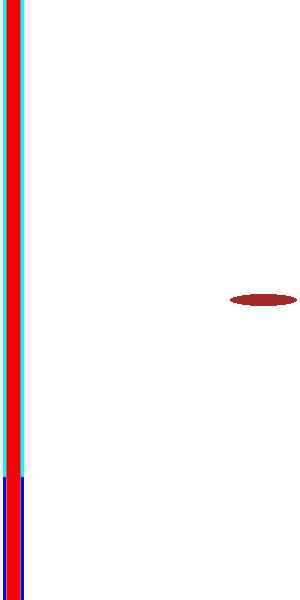

In [60]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (18,200)
plot.pixels = (300,600)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', 
               zircaloy: 'gray', ofc_uo2:'brown'}
openmc.plot_inline(plot)

Let's now build and run a standard depletion calculation, increasing the thermal power to $100\ kW$. The results will be used as the reference to compare with the MSR capabilities:

In [61]:
#Create depletion "operator"
chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 100000  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
 Reading I135 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59632
  

       33/1    0.98110    0.98252 +/- 0.00924
       34/1    1.05392    0.98549 +/- 0.00933
       35/1    0.99573    0.98590 +/- 0.00896
       36/1    0.98858    0.98600 +/- 0.00861
       37/1    0.99745    0.98643 +/- 0.00829
       38/1    1.05574    0.98890 +/- 0.00837
       39/1    0.98970    0.98893 +/- 0.00807
       40/1    0.99604    0.98917 +/- 0.00780
       41/1    0.96335    0.98834 +/- 0.00759
       42/1    0.97269    0.98785 +/- 0.00737
       43/1    0.97698    0.98752 +/- 0.00715
       44/1    1.05621    0.98954 +/- 0.00722
       45/1    0.97328    0.98907 +/- 0.00703
       46/1    1.00858    0.98962 +/- 0.00685
       47/1    1.04610    0.99114 +/- 0.00684
       48/1    0.92559    0.98942 +/- 0.00688
       49/1    1.02990    0.99045 +/- 0.00678
       50/1    1.00834    0.99090 +/- 0.00662
       51/1    1.02303    0.99169 +/- 0.00650
       52/1    0.98721    0.99158 +/- 0.00635
       53/1    0.91604    0.98982 +/- 0.00644
       54/1    0.99529    0.98995 

       82/1    0.99472    0.98187 +/- 0.00504
       83/1    0.98906    0.98197 +/- 0.00497
       84/1    0.94203    0.98143 +/- 0.00493
       85/1    0.96758    0.98124 +/- 0.00487
       86/1    0.98553    0.98130 +/- 0.00480
       87/1    1.02792    0.98190 +/- 0.00478
       88/1    0.92862    0.98122 +/- 0.00477
       89/1    1.02361    0.98176 +/- 0.00474
       90/1    0.94209    0.98126 +/- 0.00470
       91/1    1.02238    0.98177 +/- 0.00467
       92/1    0.99409    0.98192 +/- 0.00462
       93/1    0.98077    0.98191 +/- 0.00456
       94/1    0.98267    0.98191 +/- 0.00451
       95/1    0.98456    0.98195 +/- 0.00445
       96/1    1.00805    0.98225 +/- 0.00441
       97/1    0.99452    0.98239 +/- 0.00436
       98/1    0.95541    0.98208 +/- 0.00433
       99/1    1.04242    0.98276 +/- 0.00433
      100/1    0.92457    0.98212 +/- 0.00433
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Tot

[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59270
        2/1    0.67116
        3/1    0.80711
        4/1    0.86099
        5/1    0.86045
        6/1    0.91739
        7/1    0.91707
        8/1    1.00692
        9/1    0.93361
       10/1    0.95671
       11/1    0.95818
       12/1    0.97413    0.96616 +/- 0.00797
       13/1    1.04079    0.99103 +/- 0.02530
       14/1    0.99717    0.99257 +/- 0.01796
       15/1    0.92894    0.97984 +/- 0.01885
       16/1    0.93472    0.97232 +/- 0.01713
       17/1    0.95321    0.96959 +/- 0.01473
       18/1    1.02254    0.97621 +/- 0.01437
       19/1    0.98199    0.97685 +/- 0.01269
       20/1    0.95094    0.97426 +/- 0.01165
       21/1    1.008

       48/1    1.00152    0.99298 +/- 0.00620
       49/1    0.97551    0.99253 +/- 0.00606
       50/1    1.00226    0.99277 +/- 0.00591
       51/1    0.91554    0.99089 +/- 0.00607
       52/1    0.97049    0.99040 +/- 0.00594
       53/1    0.95968    0.98969 +/- 0.00584
       54/1    1.00771    0.99010 +/- 0.00572
       55/1    0.98422    0.98997 +/- 0.00560
       56/1    0.94969    0.98909 +/- 0.00554
       57/1    0.93857    0.98802 +/- 0.00553
       58/1    1.02784    0.98885 +/- 0.00548
       59/1    0.93355    0.98772 +/- 0.00548
       60/1    0.97193    0.98740 +/- 0.00538
       61/1    0.94800    0.98663 +/- 0.00533
       62/1    0.93459    0.98563 +/- 0.00532
       63/1    1.04991    0.98684 +/- 0.00536
       64/1    0.87441    0.98476 +/- 0.00566
       65/1    0.97741    0.98463 +/- 0.00555
       66/1    0.95214    0.98405 +/- 0.00548
       67/1    1.02636    0.98479 +/- 0.00544
       68/1    0.93672    0.98396 +/- 0.00541
       69/1    0.95767    0.98351 

We can now analazie the depletion results:

In [62]:
os.system('mv depletion_results.h5 ref.h5')


0

In [66]:
# We need to re-instanciate the operator and the integrator 
flow_rate = 1 #litres/sec
lambda_in = 1 / (uo2.volume / 1000 / flow_rate)
lambda_out = 1 / (ofc_uo2.volume / 1000 / flow_rate)
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_transfer_rate('UO2', ['Xe'], lambda_in, destination_material='UO2_ofc')
integrator.add_transfer_rate('UO2_ofc', ['Xe'], lambda_out, destination_material='UO2')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
 Reading I135 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/cross_sections/endfb80/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59632
  

       34/1    1.00574    0.99806 +/- 0.00929
       35/1    0.97769    0.99725 +/- 0.00895
       36/1    1.04062    0.99892 +/- 0.00876
       37/1    0.94476    0.99691 +/- 0.00866
       38/1    0.95088    0.99527 +/- 0.00851
       39/1    1.01358    0.99590 +/- 0.00824
       40/1    1.00662    0.99626 +/- 0.00796
       41/1    1.01841    0.99697 +/- 0.00774
       42/1    0.96371    0.99593 +/- 0.00756
       43/1    1.00768    0.99629 +/- 0.00734
       44/1    0.93789    0.99457 +/- 0.00732
       45/1    1.03499    0.99572 +/- 0.00720
       46/1    1.04167    0.99700 +/- 0.00712
       47/1    1.02929    0.99787 +/- 0.00698
       48/1    1.00816    0.99814 +/- 0.00680
       49/1    1.05131    0.99951 +/- 0.00676
       50/1    1.09265    1.00184 +/- 0.00699
       51/1    1.04832    1.00297 +/- 0.00691
       52/1    1.04784    1.00404 +/- 0.00683
       53/1    0.91832    1.00204 +/- 0.00696
       54/1    0.97406    1.00141 +/- 0.00683
       55/1    0.94784    1.00022 

       85/1    0.93902    0.98995 +/- 0.00438
       86/1    1.01234    0.99025 +/- 0.00433
       87/1    0.92644    0.98942 +/- 0.00435
       88/1    0.95094    0.98893 +/- 0.00432
       89/1    1.09845    0.99031 +/- 0.00449
       90/1    1.01270    0.99059 +/- 0.00444
       91/1    0.89620    0.98943 +/- 0.00454
       92/1    1.01159    0.98970 +/- 0.00449
       93/1    1.03604    0.99026 +/- 0.00447
       94/1    1.01741    0.99058 +/- 0.00443
       95/1    0.97483    0.99039 +/- 0.00438
       96/1    0.98397    0.99032 +/- 0.00433
       97/1    1.05446    0.99106 +/- 0.00434
       98/1    1.00259    0.99119 +/- 0.00430
       99/1    0.95627    0.99079 +/- 0.00427
      100/1    0.98883    0.99077 +/- 0.00422
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59142
        2/1    0.73355
        3/1    0.83553
        4/1    0.91011
        5/1    0.85612
        6/1    0.92709
        7/1    0.96777
        8/1    0.99558
        9/1    0.98257
       10/1    0.95468
       11/1    0.92306
       12/1    1.02522    0.97414 +/- 0.05108
       13/1    0.92908    0.95912 +/- 0.03310
       14/1    0.95391    0.95782 +/- 0.02344
       15/1    0.96629    0.95951 +/- 0.01823
       16/1    1.00749    0.96751 +/- 0.01690
       17/1    0.97634    0.96877 +/- 0.01434
       18/1    0.93801    0.96492 +/- 0.01300
       19/1    0.89955    0.95766 +/- 0.01357
       20/1    1.07710    0.96960 +/- 0.01703
       21/1    0.99528    0.97194 +/- 0.01558
       22/1    0.90828    0.96663 +/- 0.01518
       23/1    0.98130    0.96776 +/- 0.01401
       24/1    1.04078    0.97298 +/- 0.01398
       25/1    1.01363    0.97569 +/- 0.01329
       26/1    0.

       56/1    1.01204    0.98236 +/- 0.00625
       57/1    0.92922    0.98123 +/- 0.00622
       58/1    1.00472    0.98172 +/- 0.00611
       59/1    0.98367    0.98176 +/- 0.00598
       60/1    0.99260    0.98198 +/- 0.00586
       61/1    0.97651    0.98187 +/- 0.00575
       62/1    0.92882    0.98085 +/- 0.00573
       63/1    1.02830    0.98174 +/- 0.00569
       64/1    1.00869    0.98224 +/- 0.00561
       65/1    0.96878    0.98200 +/- 0.00551
       66/1    0.99818    0.98229 +/- 0.00542
       67/1    1.08878    0.98416 +/- 0.00564
       68/1    0.94847    0.98354 +/- 0.00558
       69/1    0.92223    0.98250 +/- 0.00558
       70/1    1.00968    0.98295 +/- 0.00550
       71/1    0.93264    0.98213 +/- 0.00548
       72/1    1.03131    0.98292 +/- 0.00544
       73/1    1.02266    0.98355 +/- 0.00539
       74/1    0.95814    0.98316 +/- 0.00532
       75/1    0.93034    0.98234 +/- 0.00530
       76/1    1.01118    0.98278 +/- 0.00524
       77/1    0.98227    0.98277 

In [67]:
os.system('mv depletion_results.h5 lump.h5')


0

In [3]:
from matplotlib.pyplot import Line2D
res_ref = openmc.deplete.Results('ref.h5')
res_lump = openmc.deplete.Results('lump.h5')
t, u238_ref_c = res_ref.get_atoms(uo2, "U238")
_, u238_ref_ofc = res_ref.get_atoms(ofc_uo2, "U238")
_, u238_lump_c = res_lump.get_atoms(uo2, "U238")
_, u238_lump_ofc = res_lump.get_atoms(ofc_uo2, "U238")

_, xe135_ref_c = res_ref.get_atoms(uo2, "Xe135")
_, xe135_ref_ofc = res_ref.get_atoms(ofc_uo2, "Xe135")
_, xe135_lump_c = res_lump.get_atoms(uo2, "Xe135")
_, xe135_lump_ofc = res_lump.get_atoms(ofc_uo2, "Xe135")

_, gr_rxe135_ref_c = res_ref.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')
_, gr_xe135_ref_ofc = res_ref.get_reaction_rate(ofc_uo2, 'Xe135', '(n,gamma)')
_, gr_xe135_lump_c = res_lump.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')
_, gr_xe135_lump_ofc = res_lump.get_reaction_rate(ofc_uo2, 'Xe135', '(n,gamma)')

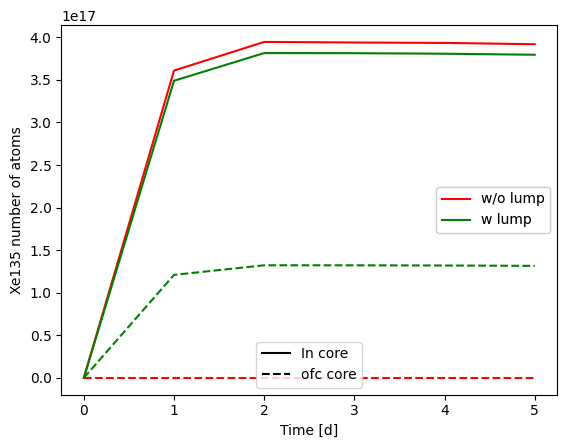

In [4]:
from matplotlib.pyplot import Line2D
line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
line3 = Line2D([0], [0], color='r')
line4 = Line2D([0], [0], color='g')
labels1 = ['In core', 'ofc core']
labels2 = ['w/o lump', 'w lump']
fig, ax = plt.subplots()
ax.plot(xe135_ref_c, color='r')
ax.plot(xe135_ref_ofc, '--', color='r')
ax.plot(xe135_lump_c, color='g')
ax.plot(xe135_lump_ofc, '--', color='g')
leg1=plt.legend([line1, line2],labels1,loc='lower center')
leg2=plt.legend([line3, line4],labels2,loc='center right')
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_xlabel('Time [d]')
ax.set_ylabel('Xe135 number of atoms')
#ax.set_yscale('log')
plt.show()